# Traffic Volume Analysis - Corridor 102

This notebook analyzes traffic volume data from various intersections along Corridor 102 throughout different times of the day:
- **Morning**: 6:00 AM - 12:00 PM
- **Afternoon**: 12:00 PM - 6:00 PM  
- **Night**: 6:00 PM - 6:00 AM

## Import Required Libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')

# Define time periods
MORNING_START, MORNING_END = 6, 12  # 6 AM - 12 PM
AFTERNOON_START, AFTERNOON_END = 12, 18  # 12 PM - 6 PM
# Night is 18-24 (6 PM - midnight) and 0-6 (midnight - 6 AM)

# Get all CSV files in the volume directory
data_dir = Path('data/volume')
csv_files = sorted(list(data_dir.glob('*.csv')))

print(f"Found {len(csv_files)} intersection files:")
for file in csv_files:
    print(f"  - {file.name}")
    
# Intersection names mapping
intersection_names = {
    '102_a_6.csv': 'A',
    '102_been_3.csv': 'Been',
    '102_c_7.csv': 'C',
    '102_elm_2.csv': 'Elm',
    '102_greenhouse_1.csv': 'Greenhouse',
    '102_i_4.csv': 'I',
    '102_j_8.csv': 'J',
    '102_moberly_10.csv': 'Moberly',
    '102_p_9.csv': 'P',
    '102_walton_5.csv': 'Walton'
}

print("\nAnalysis mode: Averaging across ALL available days per intersection")

Found 10 intersection files:
  - 102_A.csv
  - 102_Been.csv
  - 102_C.csv
  - 102_Elm.csv
  - 102_Greenhouse.csv
  - 102_I.csv
  - 102_J.csv
  - 102_Moberly.csv
  - 102_P.csv
  - 102_Walton.csv

Analysis mode: Averaging across ALL available days per intersection


## Data Loading and Processing Function

In [16]:
def load_and_process_intersection_data(file_path):
    """Load and process intersection data from CSV file, averaging across all days."""
    df = pd.read_csv(
        file_path,
        skiprows=2,
        converters={'TIME': str},
        index_col=False
    )

    # Normalize DATE/TIME columns
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    df['TIME'] = df['TIME'].str.replace('="', '', regex=False).str.replace('"', '', regex=False)
    df['TIME'] = df['TIME'].str.zfill(4)
    df['HOUR'] = df['TIME'].str[:2].astype(int)

    direction_columns = ['NBL', 'NBT', 'NBR', 'SBL', 'SBT', 'SBR',
                         'EBL', 'EBT', 'EBR', 'WBL', 'WBT', 'WBR']

    for col in direction_columns:
        if col in df.columns:
            numeric_series = pd.to_numeric(df[col].replace('*', pd.NA), errors='coerce')
            df[col] = numeric_series.fillna(0)

    existing_cols = [col for col in direction_columns if col in df.columns]
    df['TOTAL_VOLUME'] = df[existing_cols].sum(axis=1)

    # Store date range info
    df['DATE_MIN'] = df['DATE'].min()
    df['DATE_MAX'] = df['DATE'].max()
    df['NUM_DAYS'] = df['DATE'].nunique()

    return df

def filter_by_time_period(df, period='morning'):
    """Filter dataframe by time period."""
    if period == 'morning':
        return df[(df['HOUR'] >= MORNING_START) & (df['HOUR'] < MORNING_END)]
    if period == 'afternoon':
        return df[(df['HOUR'] >= AFTERNOON_START) & (df['HOUR'] < AFTERNOON_END)]
    if period == 'night':
        return df[(df['HOUR'] >= 18) | (df['HOUR'] < 6)]
    return df

def aggregate_by_hour_avg(df):
    """Aggregate traffic volume by hour, averaging across all days."""
    num_days = df['DATE'].nunique()
    hourly_totals = df.groupby('HOUR', as_index=False)['TOTAL_VOLUME'].sum()
    hourly_totals['AVG_VOLUME'] = hourly_totals['TOTAL_VOLUME'] / num_days
    return hourly_totals

print("Functions defined successfully!")

Functions defined successfully!


## Debug: Check Data Loading

In [17]:
# Test loading one file to see what's happening
test_file = csv_files[0]
print(f"Testing with: {test_file.name}\n")

# Load the data (all days)
test_df = load_and_process_intersection_data(test_file)

if test_df.empty:
    raise ValueError("No data available in the file.")

date_min = test_df['DATE_MIN'].iloc[0]
date_max = test_df['DATE_MAX'].iloc[0]
num_days = test_df['NUM_DAYS'].iloc[0]
print(f"Data spans {num_days} days: {date_min.date()} to {date_max.date()}\n")
print(f"DataFrame shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}\n")

print("First five rows of DATE / TIME / HOUR / TOTAL_VOLUME:")
print(test_df[['DATE', 'TIME', 'HOUR', 'TOTAL_VOLUME']].head())

print(f"\nUnique hours in data: {sorted(test_df['HOUR'].unique())}")
print(f"\nTotal volume statistics:")
print(test_df['TOTAL_VOLUME'].describe())

# Check morning data specifically (averaged)
morning_test = filter_by_time_period(test_df, 'morning')
morning_avg = aggregate_by_hour_avg(morning_test)
print(f"\nMorning average hourly volume (across {num_days} days):")
print(morning_avg[['HOUR', 'AVG_VOLUME']])

Testing with: 102_A.csv

Data spans 29 days: 2025-10-11 to 2025-11-08

DataFrame shape: (2784, 20)
Columns: ['DATE', 'TIME', 'INTID', 'NBL', 'NBT', 'NBR', 'SBL', 'SBT', 'SBR', 'EBL', 'EBT', 'EBR', 'WBL', 'WBT', 'WBR', 'HOUR', 'TOTAL_VOLUME', 'DATE_MIN', 'DATE_MAX', 'NUM_DAYS']

First five rows of DATE / TIME / HOUR / TOTAL_VOLUME:
        DATE  TIME  HOUR  TOTAL_VOLUME
0 2025-10-11  0000     0         134.0
1 2025-10-11  0015     0         148.0
2 2025-10-11  0030     0         106.0
3 2025-10-11  0045     0         102.0
4 2025-10-11  0100     1          93.0

Unique hours in data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]

Total volume statistics:
count    2784.000000
mean      422.231322
std       280.6

## Morning Traffic Volume (6:00 AM - 12:00 PM)

Visualizing the total vehicle volume at each intersection during morning hours.

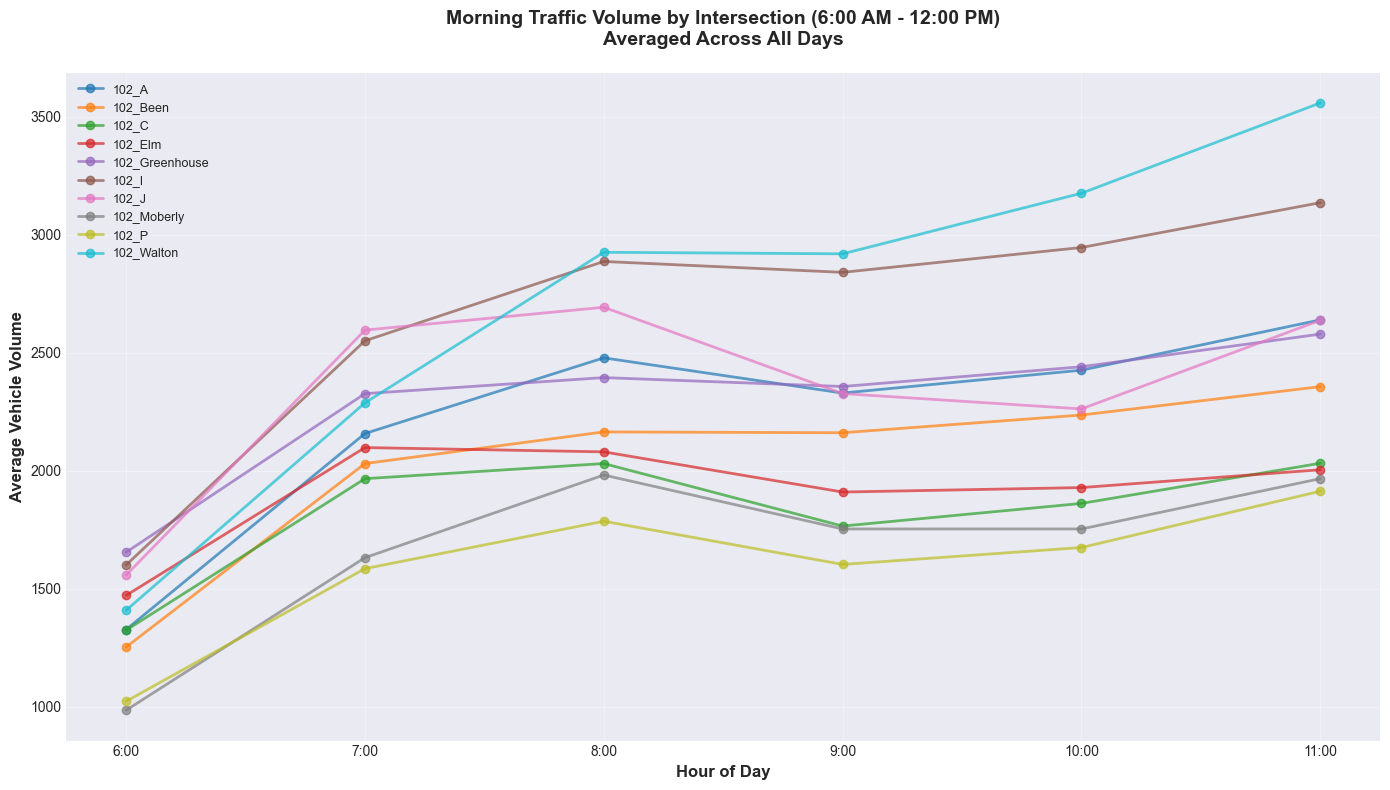


Morning Traffic Summary (Daily Averages):
-----------------------------------------------------------------
102_A                | Avg Total:  13363 | Avg/Hour:   2227 | Days: 29
102_Been             | Avg Total:  12206 | Avg/Hour:   2034 | Days: 29
102_C                | Avg Total:  10986 | Avg/Hour:   1831 | Days: 29
102_Elm              | Avg Total:  11498 | Avg/Hour:   1916 | Days: 29
102_Greenhouse       | Avg Total:  13758 | Avg/Hour:   2293 | Days: 29
102_I                | Avg Total:  15966 | Avg/Hour:   2661 | Days: 29
102_J                | Avg Total:  14078 | Avg/Hour:   2346 | Days: 19
102_Moberly          | Avg Total:  10077 | Avg/Hour:   1680 | Days: 29
102_P                | Avg Total:   9591 | Avg/Hour:   1598 | Days: 29
102_Walton           | Avg Total:  16280 | Avg/Hour:   2713 | Days: 29


In [18]:
# Process morning data for all intersections (averaged across all days)
morning_data = {}
num_days_info = {}

for file in csv_files:
    df = load_and_process_intersection_data(file)
    if df.empty:
        print(f"Skipping {file.name} (no data)")
        continue

    intersection_name = intersection_names.get(file.name, file.stem)
    num_days_info[intersection_name] = df['NUM_DAYS'].iloc[0]

    morning_df = filter_by_time_period(df, 'morning')
    hourly_data = aggregate_by_hour_avg(morning_df)
    morning_data[intersection_name] = hourly_data

fig, ax = plt.subplots(figsize=(14, 8))

for intersection_name, data in morning_data.items():
    ax.plot(data['HOUR'], data['AVG_VOLUME'], marker='o',
            linewidth=2, label=intersection_name, alpha=0.7)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Vehicle Volume', fontsize=12, fontweight='bold')
ax.set_title('Morning Traffic Volume by Intersection (6:00 AM - 12:00 PM)\nAveraged Across All Days',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(MORNING_START, MORNING_END))
ax.set_xticklabels([f'{h}:00' for h in range(MORNING_START, MORNING_END)])

plt.tight_layout()
plt.show()

print("\nMorning Traffic Summary (Daily Averages):")
print("-" * 65)
for intersection_name, data in morning_data.items():
    total_avg = data['AVG_VOLUME'].sum()
    avg_per_hour = data['AVG_VOLUME'].mean()
    days = num_days_info[intersection_name]
    print(f"{intersection_name:20s} | Avg Total: {total_avg:6.0f} | Avg/Hour: {avg_per_hour:6.0f} | Days: {days}")

## Afternoon Traffic Volume (12:00 PM - 6:00 PM)

Visualizing the total vehicle volume at each intersection during afternoon hours.

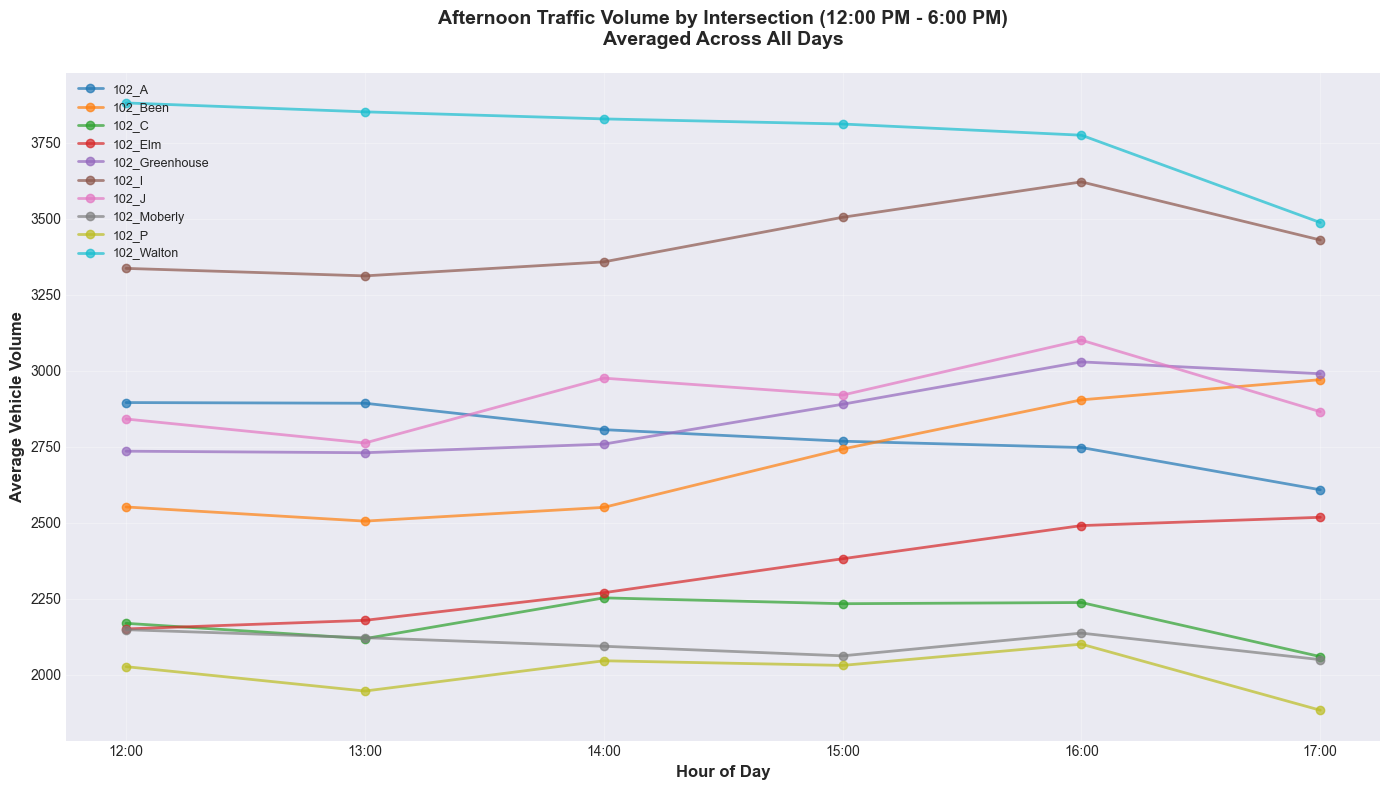


Afternoon Traffic Summary (Daily Averages):
-----------------------------------------------------------------
102_A                | Avg Total:  16723 | Avg/Hour:   2787 | Days: 29
102_Been             | Avg Total:  16229 | Avg/Hour:   2705 | Days: 29
102_C                | Avg Total:  13075 | Avg/Hour:   2179 | Days: 29
102_Elm              | Avg Total:  13993 | Avg/Hour:   2332 | Days: 29
102_Greenhouse       | Avg Total:  17137 | Avg/Hour:   2856 | Days: 29
102_I                | Avg Total:  20568 | Avg/Hour:   3428 | Days: 29
102_J                | Avg Total:  17469 | Avg/Hour:   2912 | Days: 19
102_Moberly          | Avg Total:  12616 | Avg/Hour:   2103 | Days: 29
102_P                | Avg Total:  12037 | Avg/Hour:   2006 | Days: 29
102_Walton           | Avg Total:  22640 | Avg/Hour:   3773 | Days: 29


In [19]:
# Process afternoon data for all intersections (averaged across all days)
afternoon_data = {}
num_days_info = {}

for file in csv_files:
    df = load_and_process_intersection_data(file)
    if df.empty:
        print(f"Skipping {file.name} (no data)")
        continue

    intersection_name = intersection_names.get(file.name, file.stem)
    num_days_info[intersection_name] = df['NUM_DAYS'].iloc[0]

    afternoon_df = filter_by_time_period(df, 'afternoon')
    hourly_data = aggregate_by_hour_avg(afternoon_df)
    afternoon_data[intersection_name] = hourly_data

fig, ax = plt.subplots(figsize=(14, 8))

for intersection_name, data in afternoon_data.items():
    ax.plot(data['HOUR'], data['AVG_VOLUME'], marker='o',
            linewidth=2, label=intersection_name, alpha=0.7)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Vehicle Volume', fontsize=12, fontweight='bold')
ax.set_title('Afternoon Traffic Volume by Intersection (12:00 PM - 6:00 PM)\nAveraged Across All Days',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(AFTERNOON_START, AFTERNOON_END))
ax.set_xticklabels([f'{h}:00' for h in range(AFTERNOON_START, AFTERNOON_END)])

plt.tight_layout()
plt.show()

print("\nAfternoon Traffic Summary (Daily Averages):")
print("-" * 65)
for intersection_name, data in afternoon_data.items():
    total_avg = data['AVG_VOLUME'].sum()
    avg_per_hour = data['AVG_VOLUME'].mean()
    days = num_days_info[intersection_name]
    print(f"{intersection_name:20s} | Avg Total: {total_avg:6.0f} | Avg/Hour: {avg_per_hour:6.0f} | Days: {days}")

## Night Traffic Volume (6:00 PM - 6:00 AM)

Visualizing the total vehicle volume at each intersection during night hours.

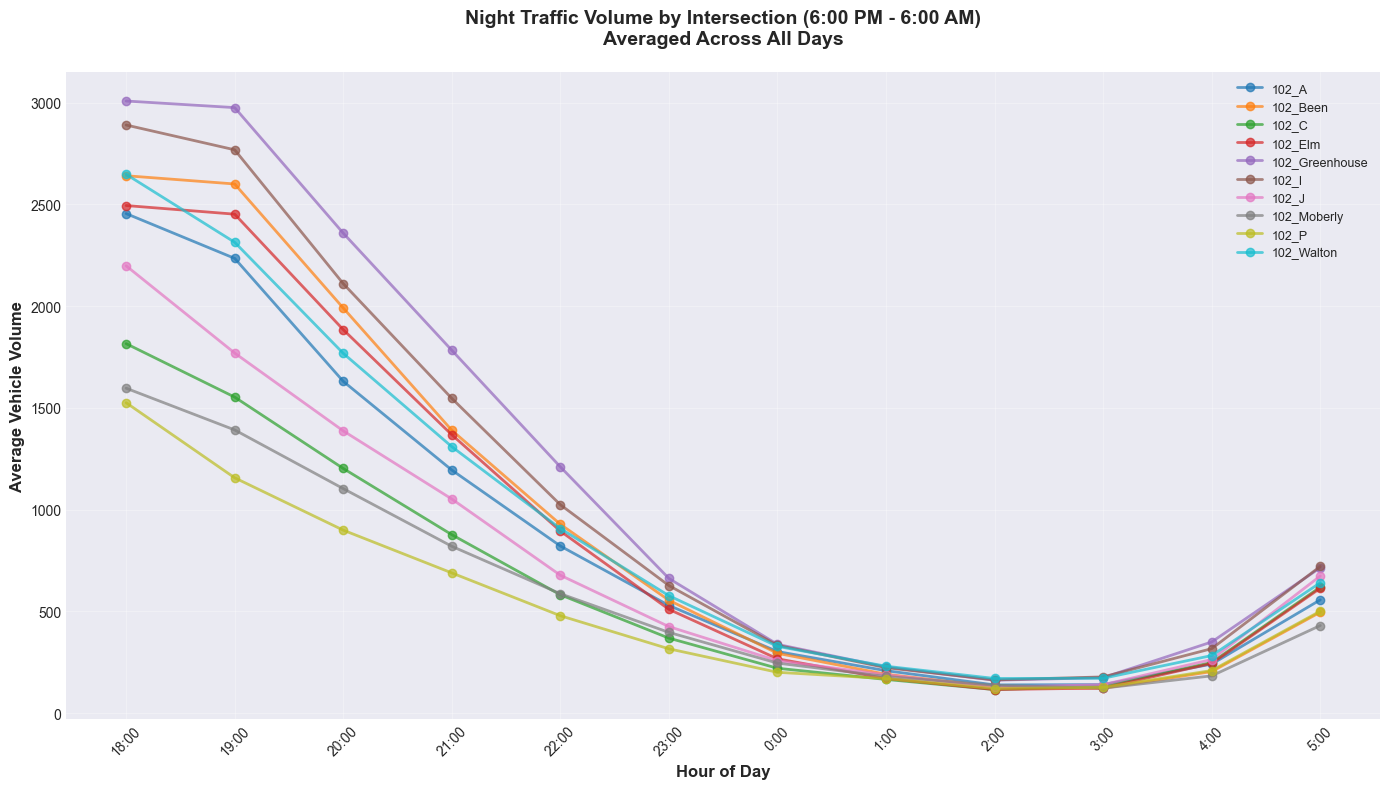


Night Traffic Summary (Daily Averages):
-----------------------------------------------------------------
102_A                | Avg Total:  10449 | Avg/Hour:    871 | Days: 29
102_Been             | Avg Total:  11536 | Avg/Hour:    961 | Days: 29
102_C                | Avg Total:   7895 | Avg/Hour:    658 | Days: 29
102_Elm              | Avg Total:  11134 | Avg/Hour:    928 | Days: 29
102_Greenhouse       | Avg Total:  13960 | Avg/Hour:   1163 | Days: 29
102_I                | Avg Total:  12899 | Avg/Hour:   1075 | Days: 29
102_J                | Avg Total:   9156 | Avg/Hour:    763 | Days: 19
102_Moberly          | Avg Total:   7190 | Avg/Hour:    599 | Days: 29
102_P                | Avg Total:   6388 | Avg/Hour:    532 | Days: 29
102_Walton           | Avg Total:  11343 | Avg/Hour:    945 | Days: 29


In [20]:
# Process night data for all intersections (averaged across all days)
night_data = {}
num_days_info = {}

for file in csv_files:
    df = load_and_process_intersection_data(file)
    if df.empty:
        print(f"Skipping {file.name} (no data)")
        continue

    intersection_name = intersection_names.get(file.name, file.stem)
    num_days_info[intersection_name] = df['NUM_DAYS'].iloc[0]

    night_df = filter_by_time_period(df, 'night')
    hourly_data = aggregate_by_hour_avg(night_df)
    night_data[intersection_name] = hourly_data

fig, ax = plt.subplots(figsize=(14, 8))

# Night hours in display order: 18-23, then 0-5
night_hours = list(range(18, 24)) + list(range(0, 6))

for intersection_name, data in night_data.items():
    # Reorder data for night display
    data_ordered = data.set_index('HOUR').reindex(night_hours).reset_index()
    ax.plot(range(len(night_hours)), data_ordered['AVG_VOLUME'],
            marker='o', linewidth=2, label=intersection_name, alpha=0.7)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Vehicle Volume', fontsize=12, fontweight='bold')
ax.set_title('Night Traffic Volume by Intersection (6:00 PM - 6:00 AM)\nAveraged Across All Days',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(len(night_hours)))
ax.set_xticklabels([f'{h}:00' for h in night_hours], rotation=45)

plt.tight_layout()
plt.show()

print("\nNight Traffic Summary (Daily Averages):")
print("-" * 65)
for intersection_name, data in night_data.items():
    total_avg = data['AVG_VOLUME'].sum()
    avg_per_hour = data['AVG_VOLUME'].mean()
    days = num_days_info[intersection_name]
    print(f"{intersection_name:20s} | Avg Total: {total_avg:6.0f} | Avg/Hour: {avg_per_hour:6.0f} | Days: {days}")

## Full-Day Traffic Trends (24 Hours)

Aggregated hourly vehicle volume across the selected day for every intersection.

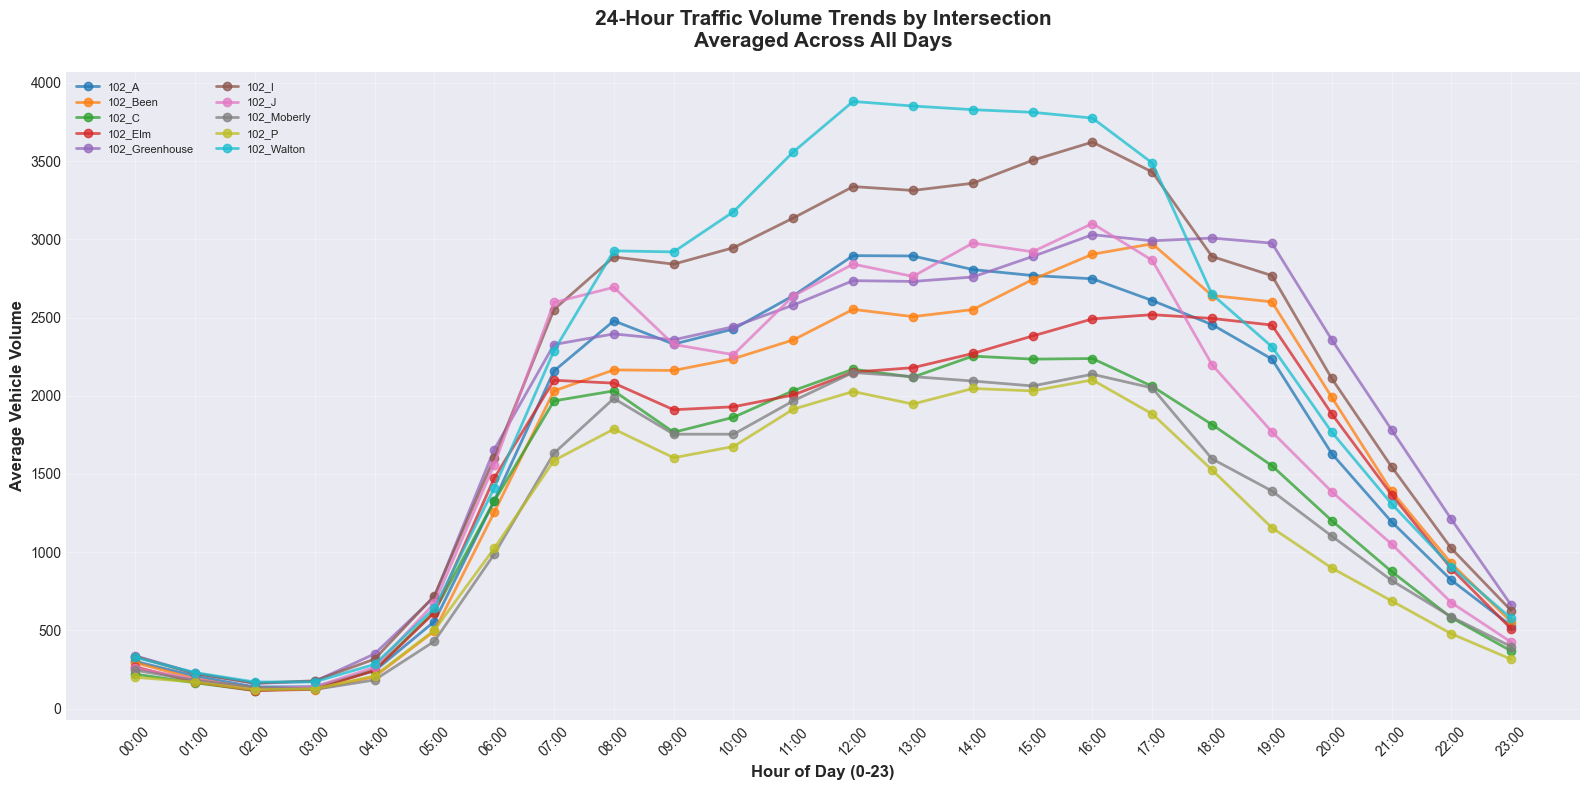


24-Hour Traffic Summary (Daily Averages):
----------------------------------------------------------------------
102_A                | Avg Daily Total:  40534 | Peak: 12:00 ( 2896) | Days: 29
102_Been             | Avg Daily Total:  39972 | Peak: 17:00 ( 2971) | Days: 29
102_C                | Avg Daily Total:  31956 | Peak: 14:00 ( 2253) | Days: 29
102_Elm              | Avg Daily Total:  36625 | Peak: 17:00 ( 2518) | Days: 29
102_Greenhouse       | Avg Daily Total:  44855 | Peak: 16:00 ( 3030) | Days: 29
102_I                | Avg Daily Total:  49432 | Peak: 16:00 ( 3622) | Days: 29
102_J                | Avg Daily Total:  40703 | Peak: 16:00 ( 3101) | Days: 19
102_Moberly          | Avg Daily Total:  29883 | Peak: 12:00 ( 2149) | Days: 29
102_P                | Avg Daily Total:  28015 | Peak: 16:00 ( 2101) | Days: 29
102_Walton           | Avg Daily Total:  50264 | Peak: 12:00 ( 3882) | Days: 29


In [21]:
# Aggregate full-day hourly trends (averaged across all days)
full_day_data = {}
num_days_info = {}
hours = list(range(24))

for file in csv_files:
    df = load_and_process_intersection_data(file)
    if df.empty:
        print(f"Skipping {file.name} (no data)")
        continue

    intersection_name = intersection_names.get(file.name, file.stem)
    num_days_info[intersection_name] = df['NUM_DAYS'].iloc[0]

    hourly_data = aggregate_by_hour_avg(df)
    hourly_data = hourly_data.set_index('HOUR').reindex(hours, fill_value=0).reset_index()
    full_day_data[intersection_name] = hourly_data

if not full_day_data:
    raise ValueError("No intersections had data")

fig, ax = plt.subplots(figsize=(16, 8))

for intersection_name, data in full_day_data.items():
    ax.plot(data['HOUR'], data['AVG_VOLUME'], marker='o', linewidth=2,
            label=intersection_name, alpha=0.75)

ax.set_xlabel('Hour of Day (0-23)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Vehicle Volume', fontsize=12, fontweight='bold')
ax.set_title('24-Hour Traffic Volume Trends by Intersection\nAveraged Across All Days',
             fontsize=15, fontweight='bold', pad=18)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45)
ax.legend(loc='upper left', fontsize=8, ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n24-Hour Traffic Summary (Daily Averages):")
print("-" * 70)
for intersection_name, data in full_day_data.items():
    total_avg = data['AVG_VOLUME'].sum()
    peak_hour = data.loc[data['AVG_VOLUME'].idxmax(), 'HOUR']
    peak_value = data['AVG_VOLUME'].max()
    days = num_days_info[intersection_name]
    print(f"{intersection_name:20s} | Avg Daily Total: {total_avg:6.0f} | Peak: {peak_hour:02d}:00 ({peak_value:5.0f}) | Days: {days}")